# CS109 Final Project Process Book

## Background & Motivation
Social media and entertainment are such pervasive parts of millennials' lives. We want to study the intersection of these two. Is it possible to predict box office success of film through sentiments expressed on social media? Stay tuned for more!

## Table of Contents
* [CS109 Final Project Process Book](#CS109-Final-Project-Process-Book)
	* [Milestone 1: Scrape and prepare data before thanksgiving](#Milestone-1:-Scrape-and-prepare-data-before-thanksgiving)
		* [Scraping and cleaning Box Office Mojo](#Scraping-and-cleaning-Box-Office-Mojo)
		* [Loading and preparing IMDB review dataset](#Loading-and-preparing-IMDB-review-dataset)
		* [Loading and preparing AFINN dictionary](#Loading-and-preparing-AFINN-dictionary)
	* [Milestone 2: Analysing and visualizing the data](#Milestone-2:-Analysing-and-visualizing-the-data)
		* [Descriptive statistics](#Descriptive-statistics)
		* [Analysis](#Analysis)
        * [Visualization](#Visualization)
	* [Milestone 3: Video and finishing touches](#Milestone-3:-Video-and-finishing-touches)
		* [Screencast video](#Screencast-video)
		* [Website](#Website)
		* [Finishing touches](#Finishing-touches)

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import statsmodels.api as sm
from statsmodels.formula.api import logit, glm, ols

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import math
from sklearn.svm import LinearSVC

## Milestone 1: Scrape and prepare data before thanksgiving

For our project we will be using data from 3 different sources
 <ul><b>Box Office Mojo (BOM)</b> (http://www.boxofficemojo.com) is a website that aggregates, in a table, a list of all movies released in a year and attributes such as how much it grossed in the opening week, how much it grossed in total and how long it aired for </ul>
 <ul><b>Large Movie Review Dataset</b> (http://ai.stanford.edu/~amaas/data/sentiment/) is a polarized dataset of movie reviews from IMDB prepared by Maas et al from Stanford. The dataset contains 25,000 entries in the training set and 25,000 entries in the test set. </ul>
 <ul><b>AFINN-111 Dictionary</b> (http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=60100) is a dictionary list of 2477 english words and phrases rated for valence with an integer from -5 to 5. Originally prepared by Finn Årup Nielsen</ul><br>
In this first milestone, we will get all the data into a format that we can start running analysis on!

### Scraping and cleaning Box Office Mojo

First we import the `requests` and `BeautifulSoup` libraries to make working with HTTP requests easier, and then easily transfer HTML content to Python data structures.

In [2]:
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests

Secondly, we prepare the data frame `movie_df` to store the data that we will scrape from BOM. We give this dataframe 9 columns: <br>
    * ranking: the ranking of the movie in its release year by gross
    * title: movie title
    * gross: how much the movie grossed while in theatres
    * Total_theaters: the total number of theaters that showed this movie
    * opening_gross: how much the movie grossed in the opening weekend (Fri-Sun)
    * opening_theaters: the total number of theaters that showed this movie in the opening weekend (Fri-Sun)
    * open_date: date of opening
    * close_date: date of closing
    * year: year of release

In [3]:
bom_df = pd.DataFrame(columns=['close_date', 'gross', 'open_date', 'opening_gross', 'opening_theaters','ranking','title','total_theaters','year'])

Now we write a function `rowInfoGrabber` that we will call in a loop over the table on the BOM webpage to grab the attributes and save them into the corresponding columns in `movie_df`.

In [4]:
def rowInfoGrabber(r):
    info = []
    # Ranking
    info.append(int(r.find("font").get_text()))
    # Title
    info.append(r.find("a").get_text())
    # Gross
    info.append(int(r.find("td", attrs={"align":"right"}).find("b").get_text().strip("$").replace(",","")))
    '''
    For the next 3 categories, we need to deal with the 2000 Anomaly "Fantasia" where there are missing numbers.
    In this case I have chosen to replace the missing values 'N/A' with the values from 'Final Destination', which
    if right above it in the movie table and differs in gross income by about $1 million, which is a small 
    difference. See the picture below for a snapshot of the anomaly in the movie table from 2000.
    '''
    # Total number of theaters
    if r.find_all("td",attrs={"align":"right"})[1].find("font").get_text().replace(",","") == 'N/A':
        info.append(2587)
    else:
        info.append(int(r.find_all("td",attrs={"align":"right"})[1].find("font").get_text().replace(",","")))
    # Opening Gross
    if r.find_all("td", attrs={"align":"right"})[2].find("font").get_text().strip("$").replace(",","") == 'N/A':
        info.append(10015822)
    else: 
        info.append(int(r.find_all("td", attrs={"align":"right"})[2].find("font").get_text().strip("$").replace(",","")))
    # Opening Number of Theaters
    if r.find_all("td", attrs={"align":"right"})[3].find("font").get_text().replace(",","") == 'N/A':
        info.append(2587)
    else:
        info.append(int(r.find_all("td", attrs={"align":"right"})[3].find("font").get_text().replace(",","")))
    # Date of Opening
    info.append(r.find_all("td", attrs={"align":"right"})[4].find("a").get_text())
    # Date of Closing: Before 2002 they didn't have a "closing" date in their tables. We must account for this.
    if (len(r.find_all("td", attrs={"align":"right"})) <= 5):
        info.append('-')
    else:
        info.append(r.find_all("td", attrs={"align":"right"})[5].find("font").get_text())
    return info

This is the image: <image src=“Example.png”>

In [5]:
fields = ["ranking", "title", "gross", "total_theaters", "opening_gross", "opening_theaters", "open_date", "close_date"]

Finally we're ready to scrape! <br>
Because IMDB was created in 1990, we will scrape that far back in BOM. So we're scraping the past 26 years (1990 - 2015). Also note that because the HTML was changed starting in 2001, our scraping will be a little different before and after then.

In [6]:
%%time
years = [1990 + i for i in range(26)]
for year in years:
    pageText = requests.get("http://www.boxofficemojo.com/yearly/chart/?yr=%(yr)d&p=.htm" % {'yr':year})
    soup = BeautifulSoup(pageText.text, "html.parser")
    movieTable = soup.find("td", attrs={"colspan":"3"})
    movieRows = movieTable.find("table").find_all("tr")[2:102]
    movie_dicts = [dict(zip(fields, rowInfoGrabber(row))) for row in movieRows]
    year_df = pd.DataFrame(movie_dicts)
    year_df['year'] = year
    bom_df = bom_df.append(year_df, ignore_index=True)
    time.sleep(1)

CPU times: user 14 s, sys: 388 ms, total: 14.4 s
Wall time: 46.3 s


In [7]:
print bom_df.shape
bom_df.head()

(2600, 9)


,close_date,gross,open_date,opening_gross,opening_theaters,ranking,title,total_theaters,year
0,-,285761243,11/16,17081997,1202,1,Home Alone,2173,1990
1,-,217631306,7/13,12191540,1101,2,Ghost,1766,1990
2,-,184208848,11/9,598257,14,3,Dances with Wolves,1636,1990
3,-,178406268,3/23,11280591,1325,4,Pretty Woman,1811,1990
4,-,135265915,3/30,25398367,2006,5,Teenage Mutant Ninja Turtles,2377,1990


Because some films do not have a close date, we will have to be careful with the close date! Next, we combine the `close_date`, `open_date` and `year` columns into two columns `close_date` and `open_date` that are time series. This will make it easier for us to work with the data in the future. 

In [8]:
# splitting the close_date and open_date into the respective month and day
bom_df['close_month'] = bom_df['close_date'].map(lambda x: '0' if x=='-' else x[:x.find('/')])
bom_df['close_day'] = bom_df['close_date'].map(lambda x: '0' if x=='-' else x[x.find('/')+1:len(x)])
bom_df['open_month'] = bom_df['open_date'].map(lambda x: x[:x.find('/')])
bom_df['open_day'] = bom_df['open_date'].map(lambda x: x[x.find('/')+1:len(x)])

# dropping the old close_date and open_date
bom_df = bom_df.drop('close_date', 1)
bom_df = bom_df.drop('open_date', 1)

# creating an open_year by turning the year column into a string and getting rid of trailing bits
bom_df['open_year'] = bom_df.year.astype(str)
bom_df['open_year'] = bom_df.open_year.map(lambda x: x[:x.find('.')])

# creating a close_year column, by looking at whether the close month is earlier/later than the open month in the year
close_month = bom_df['close_month'].astype(int)
open_month = bom_df['open_month'].astype(int)
year = bom_df['year'].astype(int)
close_year=[]
for i in range (0, len(year)):
    if close_month[i] >= open_month[i]:
        close_year.append(year[i])
    else:
        close_year.append(year[i]+1) 
bom_df['close_year'] = close_year
bom_df['close_year'] = bom_df['close_year'].astype(str)

In [9]:
# making close_date and open_date by concatenating the year, month and day
import datetime
close_date = []
for index, row in bom_df.iterrows():
    if row.close_day != '0':
        close_date.append(datetime.datetime(int(row.close_year), int(row.close_month), int(row.close_day)))
    else: 
        close_date.append(None)
bom_df['close_date'] = close_date

bom_df['open_date']=bom_df.open_year + '-' + bom_df.open_month + '-' + bom_df.open_day
bom_df['open_date']=bom_df['open_date'].apply(pd.datetools.parse)

Let's take a look at the data, now!

In [10]:
bom_df.head()

,gross,opening_gross,opening_theaters,ranking,title,total_theaters,year,close_month,close_day,open_month,open_day,open_year,close_year,close_date,open_date
0,285761243,17081997,1202,1,Home Alone,2173,1990,0,0,11,16,1990,1991,None,1990-11-16
1,217631306,12191540,1101,2,Ghost,1766,1990,0,0,7,13,1990,1991,None,1990-07-13
2,184208848,598257,14,3,Dances with Wolves,1636,1990,0,0,11,9,1990,1991,None,1990-11-09
3,178406268,11280591,1325,4,Pretty Woman,1811,1990,0,0,3,23,1990,1991,None,1990-03-23
4,135265915,25398367,2006,5,Teenage Mutant Ninja Turtles,2377,1990,0,0,3,30,1990,1991,None,1990-03-30


Let's take a look at if we can get the run times for each movie!

In [11]:
run_time=[]
for index, row in bom_df.iterrows():
    if row.close_date != None:
        run_time.append(row['close_date']-row['open_date'])
    else: 
        run_time.append('N/A')

Looks like the data is ready for us to use! Let's save this data so we're ready to use it next time. 

In [12]:
! pip install pymongo

In [13]:
# Save the movie Dictionaries corresponding to each row of the BoxOfficeMojo table.
import json # (dong)
import pymongo
from bson import json_util

# Make a dictionary out of the dataset for storage in JSON format.
movieSaved = {feature: bom_df[feature].values.tolist() for feature in bom_df.columns.values}
fp = open("allMovies.json","w")
json.dump(movieSaved, fp, default=json_util.default)
fp.close()

### Loading and preparing IMDB review dataset

We have cleaned up our IMDB review dataset in the ipython notebook `IMDB_reviews.ipynb`. From that notebook we have been able to save dictionaries of our data, which we will now call. 

In [14]:
with open("train_df_dict.json", "r") as fd:
    train_df_dict = json.load(fd)
with open("test_df_dict.json", "r") as fd:
    test_df_dict = json.load(fd)

In [15]:
train_df = pd.DataFrame(train_df_dict)
test_df = pd.DataFrame(test_df_dict)

The Stanford group distinguishes between train and test because this was relevant for their project. This may prove to be useful later, so we will keep two separate dataframes. However, for our purposes at the moment, we can combine them since the BOM data will serve as our true data set.

In [16]:
IMDB_df = train_df.append(test_df)

We want to figure out which movies from IMDB_df are also present in our BOM DF. So let's get all the movie titles in our BOM table. 

In [17]:
BOM_movie_list = bom_df.title.values.tolist()

Now let's create a mask over IMDB_df, the boolean values of which indicate whether or not a movie is in the BOM list.

In [18]:
movie_mask = [(movie in BOM_movie_list) for movie in IMDB_df.movie_name]

In [19]:
sum(movie_mask)

4111

We can now create our IMDB data frame with only those movies that also appear in the BOM tables from 1990 - 2015. 

In [20]:
IMDB_dftouse=IMDB_df[movie_mask]

Finally we want to save our dictionary of IMDB_dftouse into a JSON file for storage.

In [21]:
IMDB_dftouse_dict = {feature: IMDB_dftouse[feature].values.tolist() for feature in IMDB_dftouse.columns.values}
fp = open("IMDB_dftouse_dict.json","w")
json.dump(IMDB_dftouse_dict, fp)
fp.close()

In [22]:
# Reopen
with open("IMDB_dftouse_dict.json", "r") as fd:
    IMDB_dftouse_dict = json.load(fd)
IMDB_dftouse = pd.DataFrame(IMDB_dftouse_dict)

## Analyzing and Saving Review Attributes Using labMT Happiness Dictionary

Now let's download labMT, a word score list for sentiment analysis containing over 10,000 words. The file contains a "happiness" value, and ranks words by their happiness. It also includes mean and standard deviation, Twitter rank and Google rank.

In [23]:
url = 'http://www.plosone.org/article/fetchSingleRepresentation.action?uri=info:doi/10.1371/journal.pone.0026752.s001'
labmt = pd.read_csv(url, skiprows=2, sep='\t', index_col=0)

In [24]:
labmt.head()

,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
word,,,,,,,
laughter,1,8.50,0.9313,3600,--,--,1728
happiness,2,8.44,0.9723,1853,2458,--,1230
love,3,8.42,1.1082,25,317,328,23
happy,4,8.30,0.9949,65,1372,1313,375
laughed,5,8.26,1.1572,3334,3542,--,2332


Now let's create a happiness dictionary of (word, valence) pairs where each valence is that word's original valence minus the average valence.

In [25]:
average = labmt.happiness_average.mean()
happiness = (labmt.happiness_average - average).to_dict()

In [26]:
print "Score(happy): ", happiness['happy']
print "Score(miserable): ", happiness['miserable']
print "Best score: ", max(happiness.values())
print "Worst score: ", min(happiness.values())

Score(happy):  2.92476032088
Score(miserable):  -2.83523967912
Best score:  3.12476032088
Worst score:  -4.07523967912


In [27]:
# Save to disc
fp = open("happiness.json","w")
json.dump(happiness, fp)
fp.close()

In [28]:
# Reopen
with open("happiness.json", "r") as fp:
    happiness = json.load(fp)

Now let's collect several attributes from a given review's text body, and save all valuable information into a new data frame. First we define a function that removes stop words (all non important words from a valence perspective) from a text body.

In [29]:
from sklearn.feature_extraction import text
stopwords = text.ENGLISH_STOP_WORDS
punctuation = list('.,;:!?()[]{}`''\"@#$%^&*+-|-=~_')

def removeStopWords(text, stopwords = stopwords):
    new_text = ""
    for word in text.split():
        if word not in stopwords:
            while len(word) != 0 and word[-1] in punctuation:
                word = word[:len(word)-1]
            new_text += word + ' '
    return new_text

Now we'll write a function that returns total happiness, average happiness, total scorable words, and percentage of scorable words in a given review text.

In [30]:
'''
Name: getValenceInfo()
Inputs: review text, dictionary of happiness
Returns: a 4-tuple of (happiness total, happiness average, total # of scorable words, % of scorable words)
'''
def getValenceInfo(text, valenceDict):
    total_words = len(text.split())
    happiness_total, count_relevant = 0, 0
    for word in text.split():
        if word in valenceDict.keys():
            count_relevant += 1
            happiness_total += valenceDict[word]
    if count_relevant != 0: 
        avg_valence = 1.*happiness_total/count_relevant
    else: 
        avg_valence = 0
    return happiness_total, avg_valence, total_words, 1.*count_relevant / total_words

Now we'll write a function that, given a data frame, returns a new data frame with the concatenation of valence (happiness) info in 4 new columns: valence sum, valence average, # of scorable words, % of scorable words.

In [31]:
'''
Name: getAllInfo
Input: data frame, happiness dictionary, list of stop words
Returns: a new data frame with 4 new columns: valence_sum, valence_avg, n_scorables, pct_scorables
'''
def getAllInfo(df, valenceDict, stopwords): 
    valence_suml, valence_avgl, review_lenl, review_fractionl = [], [], [], []
    for i, row in df.iterrows():
        cleaned_review = removeStopWords(row['text'], stopwords)
        valence_sum, valence_avg, review_len, review_fraction = getValenceInfo(cleaned_review, valenceDict)
        valence_suml.append(valence_sum)
        valence_avgl.append(valence_avg)
        review_lenl.append(review_len)
        review_fractionl.append(review_fraction)
    conc = pd.DataFrame({'valence_sum': valence_suml, 'valence_avg':valence_avgl ,'n_scorables': review_lenl, 
                         'pct_scorables': review_fractionl})
    return pd.concat([df, conc], axis=1)

Now let's create a new dataframe `valence_df` with the valence statistics run on our IMDB_df. This code takes a few minutes to run.

In [32]:
%%time
valence_df = getAllInfo(IMDB_dftouse, happiness, stopwords)

CPU times: user 2min 47s, sys: 905 ms, total: 2min 48s
Wall time: 2min 48s


In [33]:
valence_df.head()

,movie_id,movie_name,positive,stars,text,url,n_scorables,pct_scorables,valence_avg,valence_sum
0,10027,Titanic,True,7,"Sure, Titanic was a good movie, the first time...",http://www.imdb.com/title/tt0120338/usercommen...,120,0.666667,0.479760,38.380826
1,10028,Titanic,True,10,When I saw this movie I was stunned by what a ...,http://www.imdb.com/title/tt0120338/usercommen...,65,0.538462,0.508760,17.806611
2,10029,Titanic,True,10,Why do people bitch about this movie and not a...,http://www.imdb.com/title/tt0120338/usercommen...,75,0.586667,0.710669,31.269454
3,10030,Titanic,True,10,"What's inexplicable? Firstly, the hatred towar...",http://www.imdb.com/title/tt0120338/usercommen...,235,0.587234,0.239253,33.016924
4,10031,Titanic,True,10,"Previously, I wrote that I loved ""Titanic"", cr...",http://www.imdb.com/title/tt0120338/usercommen...,302,0.450331,0.189907,25.827404


In [34]:
# Convert True/False to 1/0: needed to make valence_df JSON serializable, also better practice
valence_df.positive = 1.0*valence_df.positive

In [35]:
# Save to disc
fp = open("valence_df_dict.json","w")
json.dump(valence_df.to_dict(), fp)
fp.close()

In [36]:
# Reopen
with open("valence_df_dict.json", "r") as fp:
    valence_df_dict = json.load(fp)
valence_df = pd.DataFrame(valence_df_dict)

## Milestone 2: Analysing and visualizing the data

### Descriptive statistics

### Does valence correlate with stars given?

/Users/Stephen/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


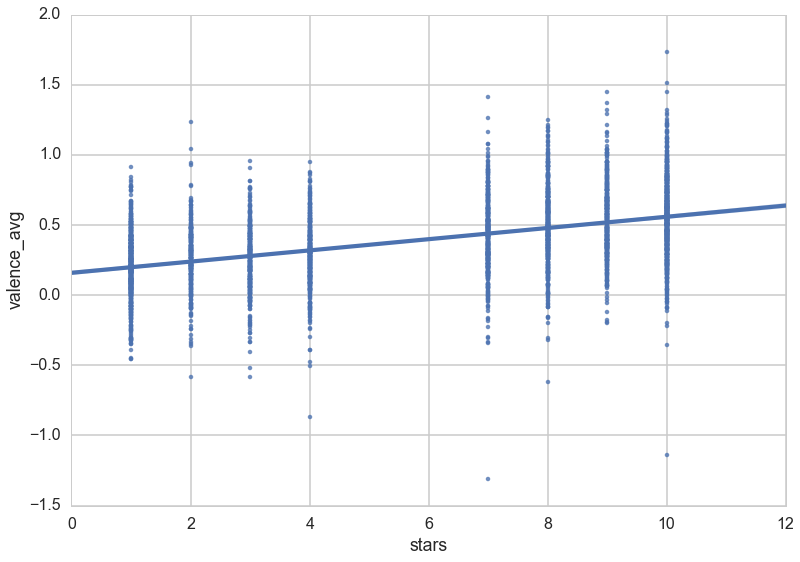

In [37]:
stars_val_avg = ols('stars ~ valence_avg',valence_df).fit()
stars_val_avg.summary()
sns.regplot(y="valence_avg", x="stars", data=valence_df)
# plt.plot(valence_df.stars,valence_df.valence_avg,'.',alpha=0.6)

Yes it does, to some extent. The explanatory power is not high though...

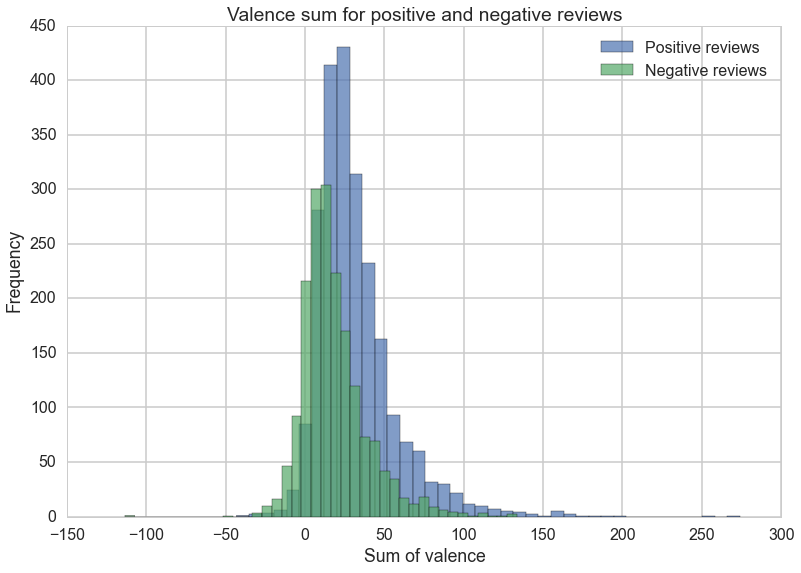

In [38]:
graph_val_avg = plt.hist(valence_df.valence_sum[valence_df.stars >=7],bins=40,alpha=0.7,label="Positive reviews")
graph_val_avg = plt.hist(valence_df.valence_sum[valence_df.stars <=4],bins=40,alpha=0.7,label="Negative reviews")
graph_val_avg = plt.title("Valence sum for positive and negative reviews")
graph_val_avg = plt.xlabel("Sum of valence")
graph_val_avg = plt.ylabel("Frequency")
graph_val_avg = plt.legend(loc='upper right')

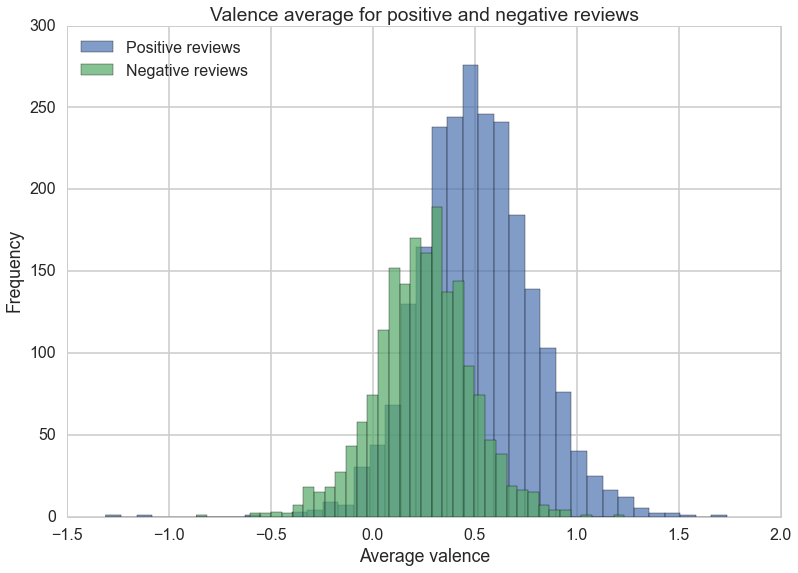

In [39]:
graph_val_avg = plt.hist(valence_df.valence_avg[valence_df.stars >=7],bins=40,alpha=0.7,label="Positive reviews")
graph_val_avg = plt.hist(valence_df.valence_avg[valence_df.stars <=4],bins=40,alpha=0.7,label="Negative reviews")
graph_val_avg = plt.title("Valence average for positive and negative reviews")
graph_val_avg = plt.xlabel("Average valence")
graph_val_avg = plt.ylabel("Frequency")
graph23 = plt.legend(loc='upper left')

Now we'll import allMoives_new.json. Remember that we still need to convert some of the columns into the datetime type so we'll do that afterwards. 

In [40]:
with open("allMovies.json", "r") as fd:
    bom_df = json.load(fd)
    bom_df = pd.DataFrame(bom_df)

In [41]:
bom_df[2572:2577]

,close_date,close_day,close_month,close_year,gross,open_date,open_day,open_month,open_year,opening_gross,opening_theaters,ranking,title,total_theaters,year
2572,{u'$date': 1446076800000},29,10,2015,27740955,1440115200000000000,21,8,2015,10542116,2766,73,Sinister 2,2799,2015
2573,{u'$date': 1448496000000},26,11,2015,27288872,1440547200000000000,26,8,2015,8111264,3355,74,No Escape,3415,2015
2574,None,0,0,2016,27001705,1445558400000000000,23,10,2015,10812861,3082,75,The Last Witch Hunter,3082,2015
2575,None,0,0,2016,26822144,1438905600000000000,7,8,2015,6610961,1603,76,Ricki and the Flash,2064,2015
2576,{u'$date': 1426723200000},19,3,2015,26501323,1420156800000000000,2,1,2015,15027415,2602,77,The Woman in Black 2: Angel of Death,2602,2015


In [42]:
# making close_date and open_date by concatenating the year, month and day
import datetime
close_date = []
for index, row in bom_df.iterrows():
    if row.close_day != '0':
        close_date.append(datetime.datetime(int(row.close_year), int(row.close_month), int(row.close_day)))
    else: 
        close_date.append(None)
bom_df['close_date'] = close_date

bom_df['open_date']=bom_df.open_year + '-' + bom_df.open_month + '-' + bom_df.open_day
bom_df['open_date']=bom_df['open_date'].apply(pd.datetools.parse)

# dropping unnecessary columns
bom_df = bom_df.drop('close_day', 1)
bom_df = bom_df.drop('close_month', 1)
bom_df = bom_df.drop('open_day', 1)
bom_df = bom_df.drop('open_month', 1)

Great! Let's take a look at all the dataframes we've created

In [43]:
bom_df

,close_date,close_year,gross,open_date,open_year,opening_gross,opening_theaters,ranking,title,total_theaters,year
0,None,1991,285761243,1990-11-16,1990,17081997,1202,1,Home Alone,2173,1990
1,None,1991,217631306,1990-07-13,1990,12191540,1101,2,Ghost,1766,1990
2,None,1991,184208848,1990-11-09,1990,598257,14,3,Dances with Wolves,1636,1990
3,None,1991,178406268,1990-03-23,1990,11280591,1325,4,Pretty Woman,1811,1990
4,None,1991,135265915,1990-03-30,1990,25398367,2006,5,Teenage Mutant Ninja Turtles,2377,1990
5,None,1991,122012643,1990-03-02,1990,17161835,1225,6,The Hunt for Red October,1817,1990
6,None,1991,119394840,1990-06-01,1990,25533700,2060,7,Total Recall,2131,1990
7,None,1991,117540947,1990-07-06,1990,21744661,2507,8,Die Hard 2: Die Harder,2507,1990
8,None,1991,103738726,1990-06-15,1990,22543911,2332,9,Dick Tracy,2332,1990
9,None,1991,91457688,1990-12-22,1990,7918560,1833,10,Kindergarten Cop,1937,1990


Now, we want to make a new dataframe `flattened_df` that we can use to run our regressions on. This dataframe will include all the columns in `movie_df` and the extra columns
* number of reviews for the movie in IMDB_df
* average stars from the reviews
* overall ranking

In [44]:
# set index to title
indexed_df = bom_df.set_index("title")

In [45]:
# use groupby to get the review_count, star_avg, valence_avg, valence_sum, pct_scorables, n_scorables
gold = valence_df.groupby("movie_name")
n_scorables = gold.n_scorables.mean()
pct_scorables = gold.pct_scorables.mean()
review_count = gold.movie_name.count()
star_avg = gold.stars.mean()
positive = gold.positive.mean()
valence_avg = gold.valence_avg.mean()
valence_sum = gold.valence_sum.mean()

In [46]:
# concatenate the two dfs into our final dataframe flattened_df
flattened_df = pd.concat([indexed_df, review_count], axis=1, join_axes=[indexed_df.index])
flattened_df.rename(columns={'movie_name': 'review_count'}, inplace=True)
flattened_df = pd.concat([flattened_df, star_avg], axis=1, join_axes=[indexed_df.index])
flattened_df.rename(columns={'stars': 'star_avg'}, inplace=True)
flattened_df = pd.concat([flattened_df, positive], axis=1, join_axes=[indexed_df.index])

flattened_df = pd.concat([flattened_df, valence_avg], axis=1, join_axes=[indexed_df.index])
# flattened_df.rename(columns={'movie_name': 'review_count'}, inplace=True)
flattened_df = pd.concat([flattened_df, valence_sum], axis=1, join_axes=[indexed_df.index])
# flattened_df.rename(columns={'movie_name': 'review_count'}, inplace=True)

flattened_df = pd.concat([flattened_df, n_scorables], axis=1, join_axes=[indexed_df.index])

flattened_df = pd.concat([flattened_df, pct_scorables], axis=1, join_axes=[indexed_df.index])


# flattened_df.rename(columns={'absolute_stars': 'abs_star_avg'}, inplace=True)

In [47]:
flattened_df.head()

,close_date,close_year,gross,open_date,open_year,opening_gross,opening_theaters,ranking,total_theaters,year,review_count,star_avg,positive,valence_avg,valence_sum,n_scorables,pct_scorables
title,,,,,,,,,,,,,,,,,
Home Alone,None,1991,285761243,1990-11-16,1990,17081997,1202,1,2173,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ghost,None,1991,217631306,1990-07-13,1990,12191540,1101,2,1766,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dances with Wolves,None,1991,184208848,1990-11-09,1990,598257,14,3,1636,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pretty Woman,None,1991,178406268,1990-03-23,1990,11280591,1325,4,1811,1990,2,1,0,0.407409,84.055626,338,0.613324
Teenage Mutant Ninja Turtles,None,1991,135265915,1990-03-30,1990,25398367,2006,5,2377,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
valence_df['abs_valence_avg'] = np.abs(valence_df['valence_avg']-np.mean(flattened_df['valence_avg']))
abs_valence_avg = gold.abs_valence_avg.mean()
flattened_df = pd.concat([flattened_df, abs_valence_avg], axis=1, join_axes=[indexed_df.index])

Let's take a look at what our dataframe looks like now!

In [49]:
flattened_df.head()

,close_date,close_year,gross,open_date,open_year,opening_gross,opening_theaters,ranking,total_theaters,year,review_count,star_avg,positive,valence_avg,valence_sum,n_scorables,pct_scorables,abs_valence_avg
title,,,,,,,,,,,,,,,,,,
Home Alone,None,1991,285761243,1990-11-16,1990,17081997,1202,1,2173,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ghost,None,1991,217631306,1990-07-13,1990,12191540,1101,2,1766,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dances with Wolves,None,1991,184208848,1990-11-09,1990,598257,14,3,1636,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pretty Woman,None,1991,178406268,1990-03-23,1990,11280591,1325,4,1811,1990,2,1,0,0.407409,84.055626,338,0.613324,0.129283
Teenage Mutant Ninja Turtles,None,1991,135265915,1990-03-30,1990,25398367,2006,5,2377,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Take only those movies that appear in the IMDB data set, i.e. those that have a review count
flattened_df = flattened_df[~flattened_df['review_count'].map(np.isnan)]
# Let's see how many fo those we have
flattened_df.shape

(334, 18)

In [51]:
flattened_df.head()

,close_date,close_year,gross,open_date,open_year,opening_gross,opening_theaters,ranking,total_theaters,year,review_count,star_avg,positive,valence_avg,valence_sum,n_scorables,pct_scorables,abs_valence_avg
title,,,,,,,,,,,,,,,,,,
Pretty Woman,None,1991,178406268,1990-03-23,1990,11280591,1325,4,1811,1990,2,1.000000,0.0,0.407409,84.055626,338.000000,0.613324,0.129283
Dick Tracy,None,1991,103738726,1990-06-15,1990,22543911,2332,9,2332,1990,24,8.875000,1.0,0.619329,46.075866,142.750000,0.580769,0.294604
Flatliners,None,1991,61489265,1990-08-10,1990,10034685,1319,18,1483,1990,30,6.966667,0.8,0.341229,27.310654,145.866667,0.616311,0.164876
Problem Child,None,1991,53470891,1990-07-27,1990,10026900,1714,21,1769,1990,8,2.500000,0.0,0.181693,15.963458,120.000000,0.607353,0.192622
Marked for Death,None,1991,46044396,1990-10-05,1990,11790047,1968,27,1974,1990,3,4.000000,0.0,0.052945,10.623149,376.000000,0.564525,0.277000


In [52]:
inflation = pd.read_csv("inf.csv")

In [53]:
years_90 = range(1990,2015)
infdict = {}

infindex = 0
infvalue = 1

testlist = []
for row in inflation.values:
    currentval = 1 + (row[1]/100)
    cuminf = infvalue*currentval
    infdict[years_90[infindex]] = cuminf
    infindex += 1
    infvalue = cuminf
    testlist.append(cuminf)

inframe = pd.DataFrame(data=testlist, index=range(1990,2015))

In [55]:
infdict

{1990: 1.0539795644,
 1991: 1.098615219150804,
 1992: 1.1318902930939463,
 1993: 1.1652998117775315,
 1994: 1.1956843237413164,
 1995: 1.229228287177842,
 1996: 1.2652594783591868,
 1997: 1.2948373218617284,
 1998: 1.3149368109750392,
 1999: 1.3437079860225376,
 2000: 1.3890830868495474,
 2001: 1.4283409518690031,
 2002: 1.4509948911070383,
 2003: 1.4839338531885458,
 2004: 1.5236622748059583,
 2005: 1.5753562785628925,
 2006: 1.626176391500925,
 2007: 1.6725658779300527,
 2008: 1.7367773595171863,
 2009: 1.7306023124666896,
 2010: 1.7589849421993997,
 2011: 1.814513310047201,
 2012: 1.852061710150393,
 2013: 1.8791913148899477,
 2014: 1.909675988181881}

In [57]:
newgross, newopengross = [], []
for gross, opengross, openyr in zip(flattened_df.gross, flattened_df.opening_gross, flattened_df.open_year):
    newgross.append(infdict[int(openyr)]*gross)
    newopengross.append(infdict[int(openyr)]*opengross)

In [58]:
dftouse = flattened_df
dftouse['adj_gross'] = newgross
dftouse['adj_opening_gross'] = newopengross

In [60]:
# creating binary variables of adjusted grossing for classifications
dftouse['adj_gross_bin'] = 1*(dftouse.adj_gross>np.mean(dftouse.adj_gross))
dftouse['adj_opening_gross_bin'] = 1*(dftouse.adj_opening_gross>np.mean(dftouse.adj_opening_gross))

In [61]:
dftouse.head()

,close_date,close_year,gross,open_date,open_year,opening_gross,opening_theaters,ranking,total_theaters,year,review_count,star_avg,positive,valence_avg,valence_sum,n_scorables,pct_scorables,abs_valence_avg,adj_gross,adj_opening_gross,adj_gross_bin,adj_opening_gross_bin
title,,,,,,,,,,,,,,,,,,,,,,
Pretty Woman,None,1991,178406268,1990-03-23,1990,11280591,1325,4,1811,1990,2,1.000000,0.0,0.407409,84.055626,338.000000,0.613324,0.129283,1.880366e+08,11889512.388355,1,0
Dick Tracy,None,1991,103738726,1990-06-15,1990,22543911,2332,9,2332,1990,24,8.875000,1.0,0.619329,46.075866,142.750000,0.580769,0.294604,1.093385e+08,23760821.495652,1,1
Flatliners,None,1991,61489265,1990-08-10,1990,10034685,1319,18,1483,1990,30,6.966667,0.8,0.341229,27.310654,145.866667,0.616311,0.164876,6.480843e+07,10576352.925191,0,0
Problem Child,None,1991,53470891,1990-07-27,1990,10026900,1714,21,1769,1990,8,2.500000,0.0,0.181693,15.963458,120.000000,0.607353,0.192622,5.635723e+07,10568147.694282,0,0
Marked for Death,None,1991,46044396,1990-10-05,1990,11790047,1968,27,1974,1990,3,4.000000,0.0,0.052945,10.623149,376.000000,0.564525,0.277000,4.852985e+07,12426468.601316,0,0


Now that we have adjusted for inflation, we can remove the previous gross and all columns pertaining to date (except perhaps `year`, since it's interesting).

In [62]:
keep = ['ranking','total_theaters', 'year', 'review_count', 'star_avg','positive','valence_avg','valence_sum',
        'n_scorables','pct_scorables','abs_valence_avg','adj_gross', 'adj_opening_gross', 'adj_gross_bin','adj_opening_gross_bin']
dftouse = dftouse[keep]

In [65]:
# Let's see the new data frame
dftouse.head()

,ranking,total_theaters,year,review_count,star_avg,positive,valence_avg,valence_sum,n_scorables,pct_scorables,abs_valence_avg,adj_gross,adj_opening_gross,adj_gross_bin,adj_opening_gross_bin
title,,,,,,,,,,,,,,,
Pretty Woman,4,1811,1990,2,1.000000,0.0,0.407409,84.055626,338.000000,0.613324,0.129283,1.880366e+08,11889512.388355,1,0
Dick Tracy,9,2332,1990,24,8.875000,1.0,0.619329,46.075866,142.750000,0.580769,0.294604,1.093385e+08,23760821.495652,1,1
Flatliners,18,1483,1990,30,6.966667,0.8,0.341229,27.310654,145.866667,0.616311,0.164876,6.480843e+07,10576352.925191,0,0
Problem Child,21,1769,1990,8,2.500000,0.0,0.181693,15.963458,120.000000,0.607353,0.192622,5.635723e+07,10568147.694282,0,0
Marked for Death,27,1974,1990,3,4.000000,0.0,0.052945,10.623149,376.000000,0.564525,0.277000,4.852985e+07,12426468.601316,0,0


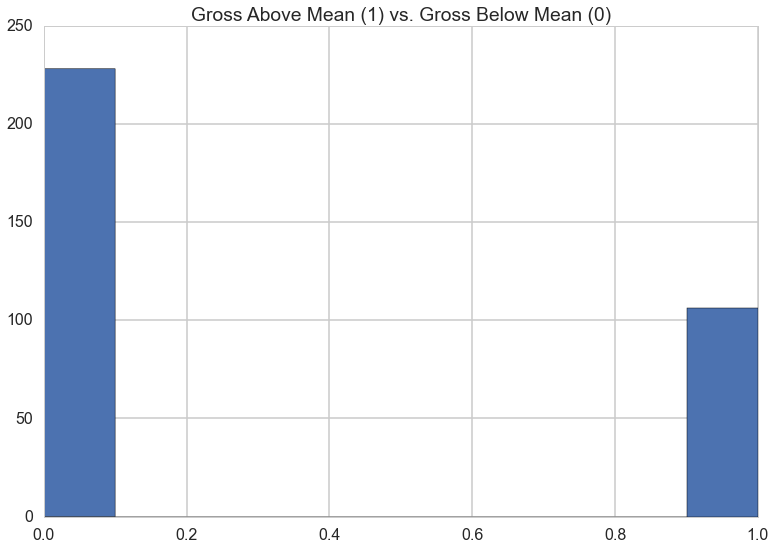

In [68]:
plt.hist(dftouse.adj_gross_bin)
plt.title("Gross Above Mean (1) vs. Gross Below Mean (0)")

In [69]:
# Let's save
fp = open("dftouse.json","w")
json.dump(dftouse.to_dict(), fp)
fp.close()

- useful to consider polarizing reviews actually predict the box office performance
- measures of dispersion on the sentiment analysis
- different types of distributions you have in a given review
- how frequently are certain words used
- average length of words
- average document lengths
- ratio between high valence words and low valence words
- we can do different sentiment scores based on different sentiment dictionaries
- could use a BOW model (have the corpus of words in the reviews) & shrink down for regularization 

- We can adopt the hypothesis that stars predict box office gross
- Or hypothesis that evry polarized responses predict box office gross
- okay to have dud hypothesis

- Graded on the effort we put in - low unimpressive results should not be equated with not having much work to do. We can make up for it via lit reviews or extra research. 

### Analysis

In [147]:
# Reopen dftouse
with open("dftouse.json", "r") as fp:
    dftouse_dict = json.load(fp)
dftouse = pd.DataFrame(dftouse_dict)

We have chosen to only use opening grossing of movies as our y-variable. This is because the time for which the movie is open is standardized. We considered using (total grossing)/(total time in theaters) as the y-variable, but this was not feasible because we do not have a closing date for every movie and therefore could not calculate the total time in theaters fo every review.

Let's remove outliers from the dataset, so that we can more easily see trends. An outlier in column valence_avg is defined as a point that it more than 3 standard deviations away from the mean.

In [154]:
def is_not_outlier(num, avg, sd, m = 3.):
    return np.absolute(num-avg) < m*sd

In [155]:
v_avg_avg = np.mean(dftouse.valence_avg)
v_avg_sd = np.std(dftouse.valence_avg)
mask = [is_not_outlier(num, v_avg_avg, v_avg_sd) for num in dftouse.valence_avg]

Let's see how many outliers we removed.

In [156]:
len(dftouse.valence_avg) - sum(mask)

2

In [157]:
dftouse = dftouse[mask]

Now let's make scatter plots for each review, of opening gross values against average valence, sum valence, and polarity (absolute valence_avg).

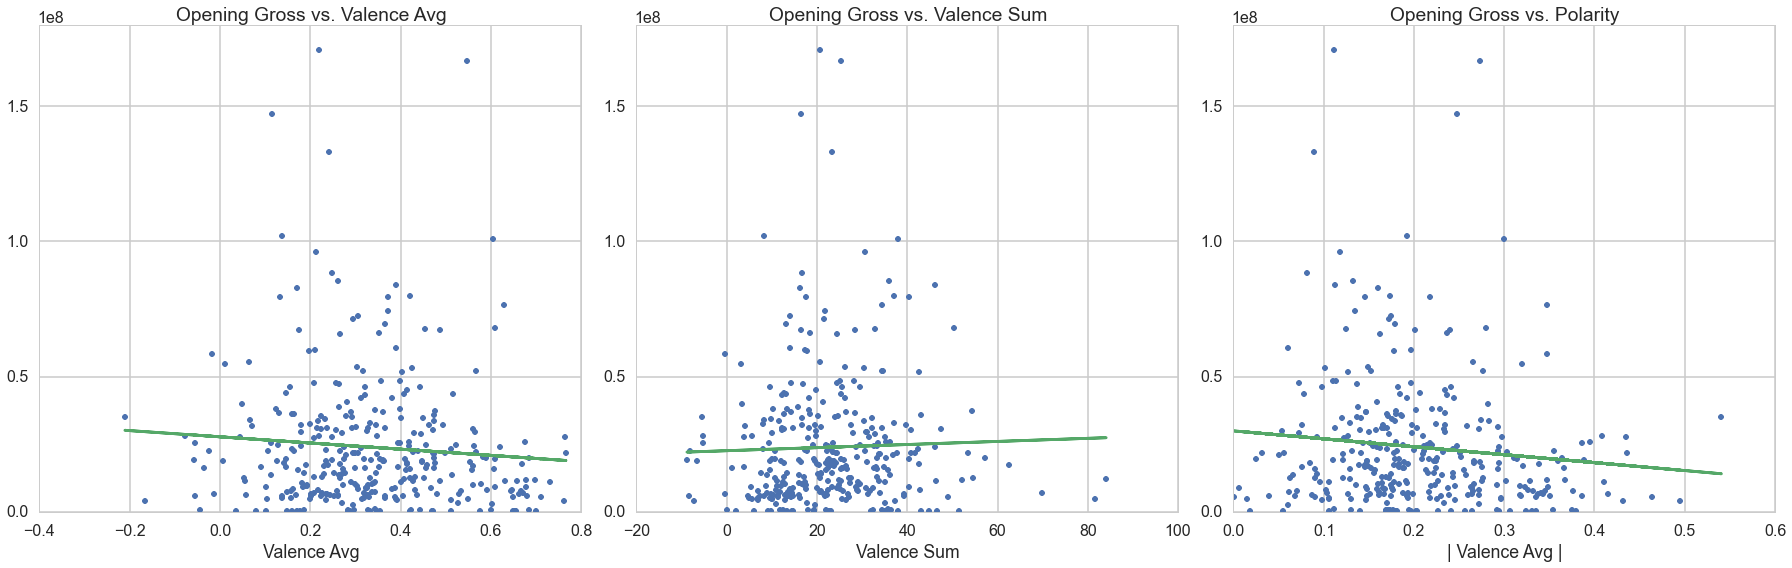

In [158]:
# First, let's make scatter plots of opening gross numbers against valence_avg
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(25, 8),tight_layout = True)
titles = ["Opening Gross vs. Valence Avg", "Opening Gross vs. Valence Sum", "Opening Gross vs. Polarity"]
xlabels = ["Valence Avg", "Valence Sum", "| Valence Avg |"]
x = [dftouse.valence_avg, dftouse.valence_sum, dftouse.abs_valence_avg]
for (ax, title, xlabel, x) in zip(axes.ravel(), titles, xlabels, x):
    m, b = np.polyfit(x, dftouse.adj_opening_gross, 1)
#     ax.plot(x, m*x + b, '-')
    ax.plot(x, dftouse.adj_opening_gross, '.',x, m*x + b, '-')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylim(-1000, 1.8*1e8)

The above scatterplots seem to show that there is little correlation between opening gross and all three predictors.

However, we foresee a limitation to our analysis. The reviews dataset we have was constructed by taking the most polarizing reviews that did not represent the realistic viewership response. For example, very successful movies that have bad reviews might be predicted as lowly grossing because they have a few poor reviews and it is in our dataset. To curb this problem, we are going to divide our dataset into movies that that received poor reviews and movies receivin good reviews. This is defined as the reviewer giving less than 4 stars and the reviewer giving more than 7 stars. We then conduct our regression analysis for each of these sub-datasets. Our hypothesis is that good, higher grossing movies that received poor reviews will receive less poorer reviews on average. In contrast, the good movies that received good reviews should receive higher reviews on average. We create these separate datasets below.

In [163]:
dftouse_small = dftouse[dftouse['valence_avg'] <= np.mean(dftouse['valence_avg'])]
dftouse_large = dftouse[dftouse['valence_avg'] >= np.mean(dftouse['valence_avg'])]

In [164]:
# And now, regressions
reg_list = []

og_val_avg = ols('adj_opening_gross ~ valence_avg',dftouse).fit()
og_val_avg_small = ols('adj_opening_gross ~ valence_avg',dftouse_small).fit()
og_val_avg_large = ols('adj_opening_gross ~ valence_avg',dftouse_large).fit()
og_abs_val_avg_large = ols('adj_opening_gross ~ abs_valence_avg',dftouse).fit()

og_val_sum = ols('adj_opening_gross ~ valence_sum',dftouse).fit()
og_val_sum_small = ols('adj_opening_gross ~ valence_sum',dftouse_small).fit()
og_val_sum_large = ols('adj_opening_gross ~ valence_sum',dftouse_large).fit()

reg_list.append(og_val_avg)
reg_list.append(og_val_avg)
reg_list.append(og_val_avg_small)
reg_list.append(og_val_avg_large)
reg_list.append(og_abs_val_avg_large)

reg_list.append(og_val_sum)
reg_list.append(og_val_sum_small)
reg_list.append(og_val_sum_large)

og_val_avg.summary()
og_val_avg_small.summary()
og_val_avg_large.summary()
og_abs_val_avg_large.summary()

og_val_sum.summary()
og_val_sum_small.summary()
og_val_sum_large.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      adj_opening_gross   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                 6.968e-06
Date:                Sat, 05 Dec 2015   Prob (F-statistic):              0.998
Time:                        15:55:44   Log-Likelihood:                -2829.6
No. Observations:                 154   AIC:                             5663.
Df Residuals:                     152   BIC:                             5669.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    2.265e+07   5.08e+06      4.456      0.000      1.26e+07  3.27e+07
valence_sum   409.0778   1.55e+05      0.003      0.998     -3.06e+05  3.07e+05
==============================================================================
Omnibus:                      105.108   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              747.547
Skew:                           2.478   Prob(JB):                    4.70e-163
Kurtosis:                      12.589   Cond. No.                         89.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [167]:
logit_model = logit('adj_gross_bin ~ abs_valence_avg',dftouse).fit()
print logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.620079
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          adj_gross_bin   No. Observations:                  331
Model:                          Logit   Df Residuals:                      329
Method:                           MLE   Df Model:                            1
Date:                Sat, 05 Dec 2015   Pseudo R-squ.:                 0.01112
Time:                        15:56:02   Log-Likelihood:                -205.25
converged:                       True   LL-Null:                       -207.55
                                        LLR p-value:                   0.03168
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -0.1770      0.292     -0.605      0.545        -0.750     0.396
abs_valence_av

In [ ]:
### Classify things!


clfsvm=LinearSVC(loss="hinge")
# Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=adjframe[lcols].values
Yresp=adjframe['RESP'].adj_opening_gross

### Visualization

## Milestone 3: Video and finishing touches

### Screencast video

### Website

### Finishing touches

Our analysis seems to show that valence is not a good predictor of grossing for movies. This is perhaps because our valence values are not representative of the reviews.

At this stage, we would like at least establish a relationship between movie grossing and review